# Index - compare performance
The step between index and comparing record pairs is slow. The reason is the sampling of a dataframe out of the MultiIndex. This notebook compares the performance of several methods. It also gives an indication of the time used. 

In [1]:
import recordlinkage
from recordlinkage.datasets import load_febrl4

In [18]:
dfA, dfB = load_febrl4()
dfA = dfA[0:2500]
dfB = dfB[0:2000]

c_index = recordlinkage.Pairs(dfA, dfB)
pairs = c_index.full()

In [3]:
print ("The number of record pairs", len(pairs))

The number of record pairs 5000000


## Default implementation

In [4]:
# The current implementation
from recordlinkage.utils import _resample

In [5]:
%timeit _resample(dfA, pairs, 0)
%timeit _resample(dfB, pairs, 1)

1 loop, best of 3: 16.4 s per loop
1 loop, best of 3: 16.6 s per loop


In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import time

log_steps = np.arange(50000, 5000001, 50000)
comp_times = []

for i in log_steps:
    
    # start timer
    start_time = time.time()
    
    # Computation
    _resample(dfA, pairs[0:i], 0)
    _resample(dfB, pairs[0:i], 1)

    # end timer
    comp_time = time.time() - start_time
    comp_times.append(comp_time)
    
#     print("step", i, "in", comp_time, "seconds")

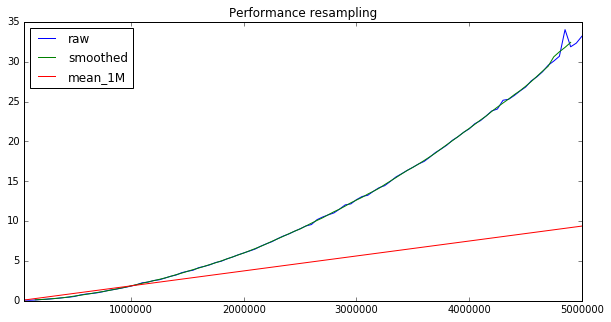

In [7]:
df_plot = pd.DataFrame(index=log_steps)

df_plot['raw'] = comp_times
df_plot['smoothed'] = pd.rolling_mean(df_plot['raw'], 5, center=True)
df_plot['mean_1M'] = log_steps*df_plot['smoothed'][1e6]/1e6

df_plot.plot.line(title="Performance resampling", figsize=(10, 5))

## Implementation 1
Using ``.loc``. This is the default implementation.

In [8]:
def _resample1(frame, index, level_i):

    data = frame.loc[index.get_level_values(level_i)]
    data.index = index

    return data

In [9]:
%%timeit 
_resample1(dfA, pairs, 0)
_resample1(dfB, pairs, 1)

1 loop, best of 3: 16.3 s per loop
1 loop, best of 3: 16.5 s per loop


## Implementation 2
Using ``.ix``. This index method is not fitting our needs, because it can locate on index label or index number. Added this locate method for comparison.

In [10]:
def _resample2(frame, index, level_i):

    data = frame.ix[index.get_level_values(level_i)]
    data.index = index

    return data

In [11]:
%%timeit 

_resample2(dfA, pairs, 0)
_resample2(dfB, pairs, 1)

1 loop, best of 3: 16.5 s per loop
1 loop, best of 3: 16.9 s per loop


## Implementation 3
Split files into parts such that the number of record pairs has a maximum size of 1e6. 

In [19]:
%%timeit

c_index = recordlinkage.Pairs(dfA, dfB, chunks=(1000, 1000))

for pairs in c_index.full():
    
    _resample1(dfA, pairs, 0)
    _resample1(dfB, pairs, 1)


1 loop, best of 3: 8.77 s per loop


In [20]:
df_plot.loc[5e6]

raw         33.195286
smoothed          NaN
mean_1M      9.374644
Name: 5000000, dtype: float64

## Implementation 4
In this implementation, we are not returning the indexing 

In [21]:
def block_resample(df_a, df_b, on=None):

    pairs = df_a.reset_index().merge(
        df_b.reset_index(),
        how='inner',
        on=on
    ).set_index([df_a.index.name, df_b.index.name])

    return pairs

In [22]:
dfA_4 = dfA.copy()
dfB_4 = dfB.copy()

dfA_4.index.name = 'index_A'
dfB_4.index.name = 'index_B'

dfA_4['join_col'] = 1
dfB_4['join_col'] = 1

In [23]:
%timeit block_resample(dfA_4, dfB_4, 'join_col')

1 loop, best of 3: 6.1 s per loop


In [24]:
df_plot.loc[5e6]

raw         33.195286
smoothed          NaN
mean_1M      9.374644
Name: 5000000, dtype: float64